# ECE271A Statistical Learning HW2
## Jinyu Zhao A53324435
### Question A

In [1]:
import numpy as np
import scipy.io

mat = scipy.io.loadmat('TrainingSamplesDCT_8_new')
FG = mat["TrainsampleDCT_FG"]
BG = mat["TrainsampleDCT_BG"]
total = FG.shape[0] + BG.shape[0]
prior_1  = FG.shape[0] / total
prior_0 = BG.shape[0] / total
# Question A:

print("Prior probability of Cheetah is:", prior_1)
print("Prior probability of grass is:", prior_0)

Prior probability of Cheetah is: 0.1918649270913277
Prior probability of grass is: 0.8081350729086723


The result is the same as last week. 
<br>Since last week I'm using "common sense" to estimate a binomial distribution
which is just a multinomial distribution with n = 2. 
<br>And in this case, the MLE for multinomial distribution agrees
with common sense estimation.

Before computing the MLE for the parameters of Gaussian, we need to check that the Hessian for our log likelihood function is negative definite, so that it indeed has a maximum. Note that the $\mathcal{L} = \sum_{i = 1}^{n}-log(\sqrt{2 \pi |\Sigma^{-1}|}) + \sum_{i = 1}^{n}(-\frac{1}{2}(x_i - \mu)^T\Sigma^{-1}(x_i - \mu))$<br>
The Hessian for $\mathcal{L}$ is $-2\cdot \Sigma^{-1}$, now we need to check $-2\cdot \Sigma^{-1}$ is negative definite. In fact, since $\Sigma$ is a real symetric matrix with all entries nonzero, it is a positive definite matrix. Thus $-2 \cdot \Sigma$ is a negative definite.

In [2]:
def is_neg_def(x):
    return np.all(np.linalg.eigvals(x) < 0)
def Gaussian_MLE_cheetah(data):
    N = len(data)
    mu = 1 / N * np.sum(data, axis= 0)
    var = np.zeros((64,64))
    for i, item in enumerate(data):
        vec = (item - mu).reshape(64,1)
        var += np.matmul(vec, vec.T)
    print(is_neg_def(np.linalg.inv(-var)))
    return mu, var
mu_1, var_1 = Gaussian_MLE_cheetah(FG)
mu_0, var_0 = Gaussian_MLE_cheetah(BG)

True
True


### Question B
Plot all 64 features

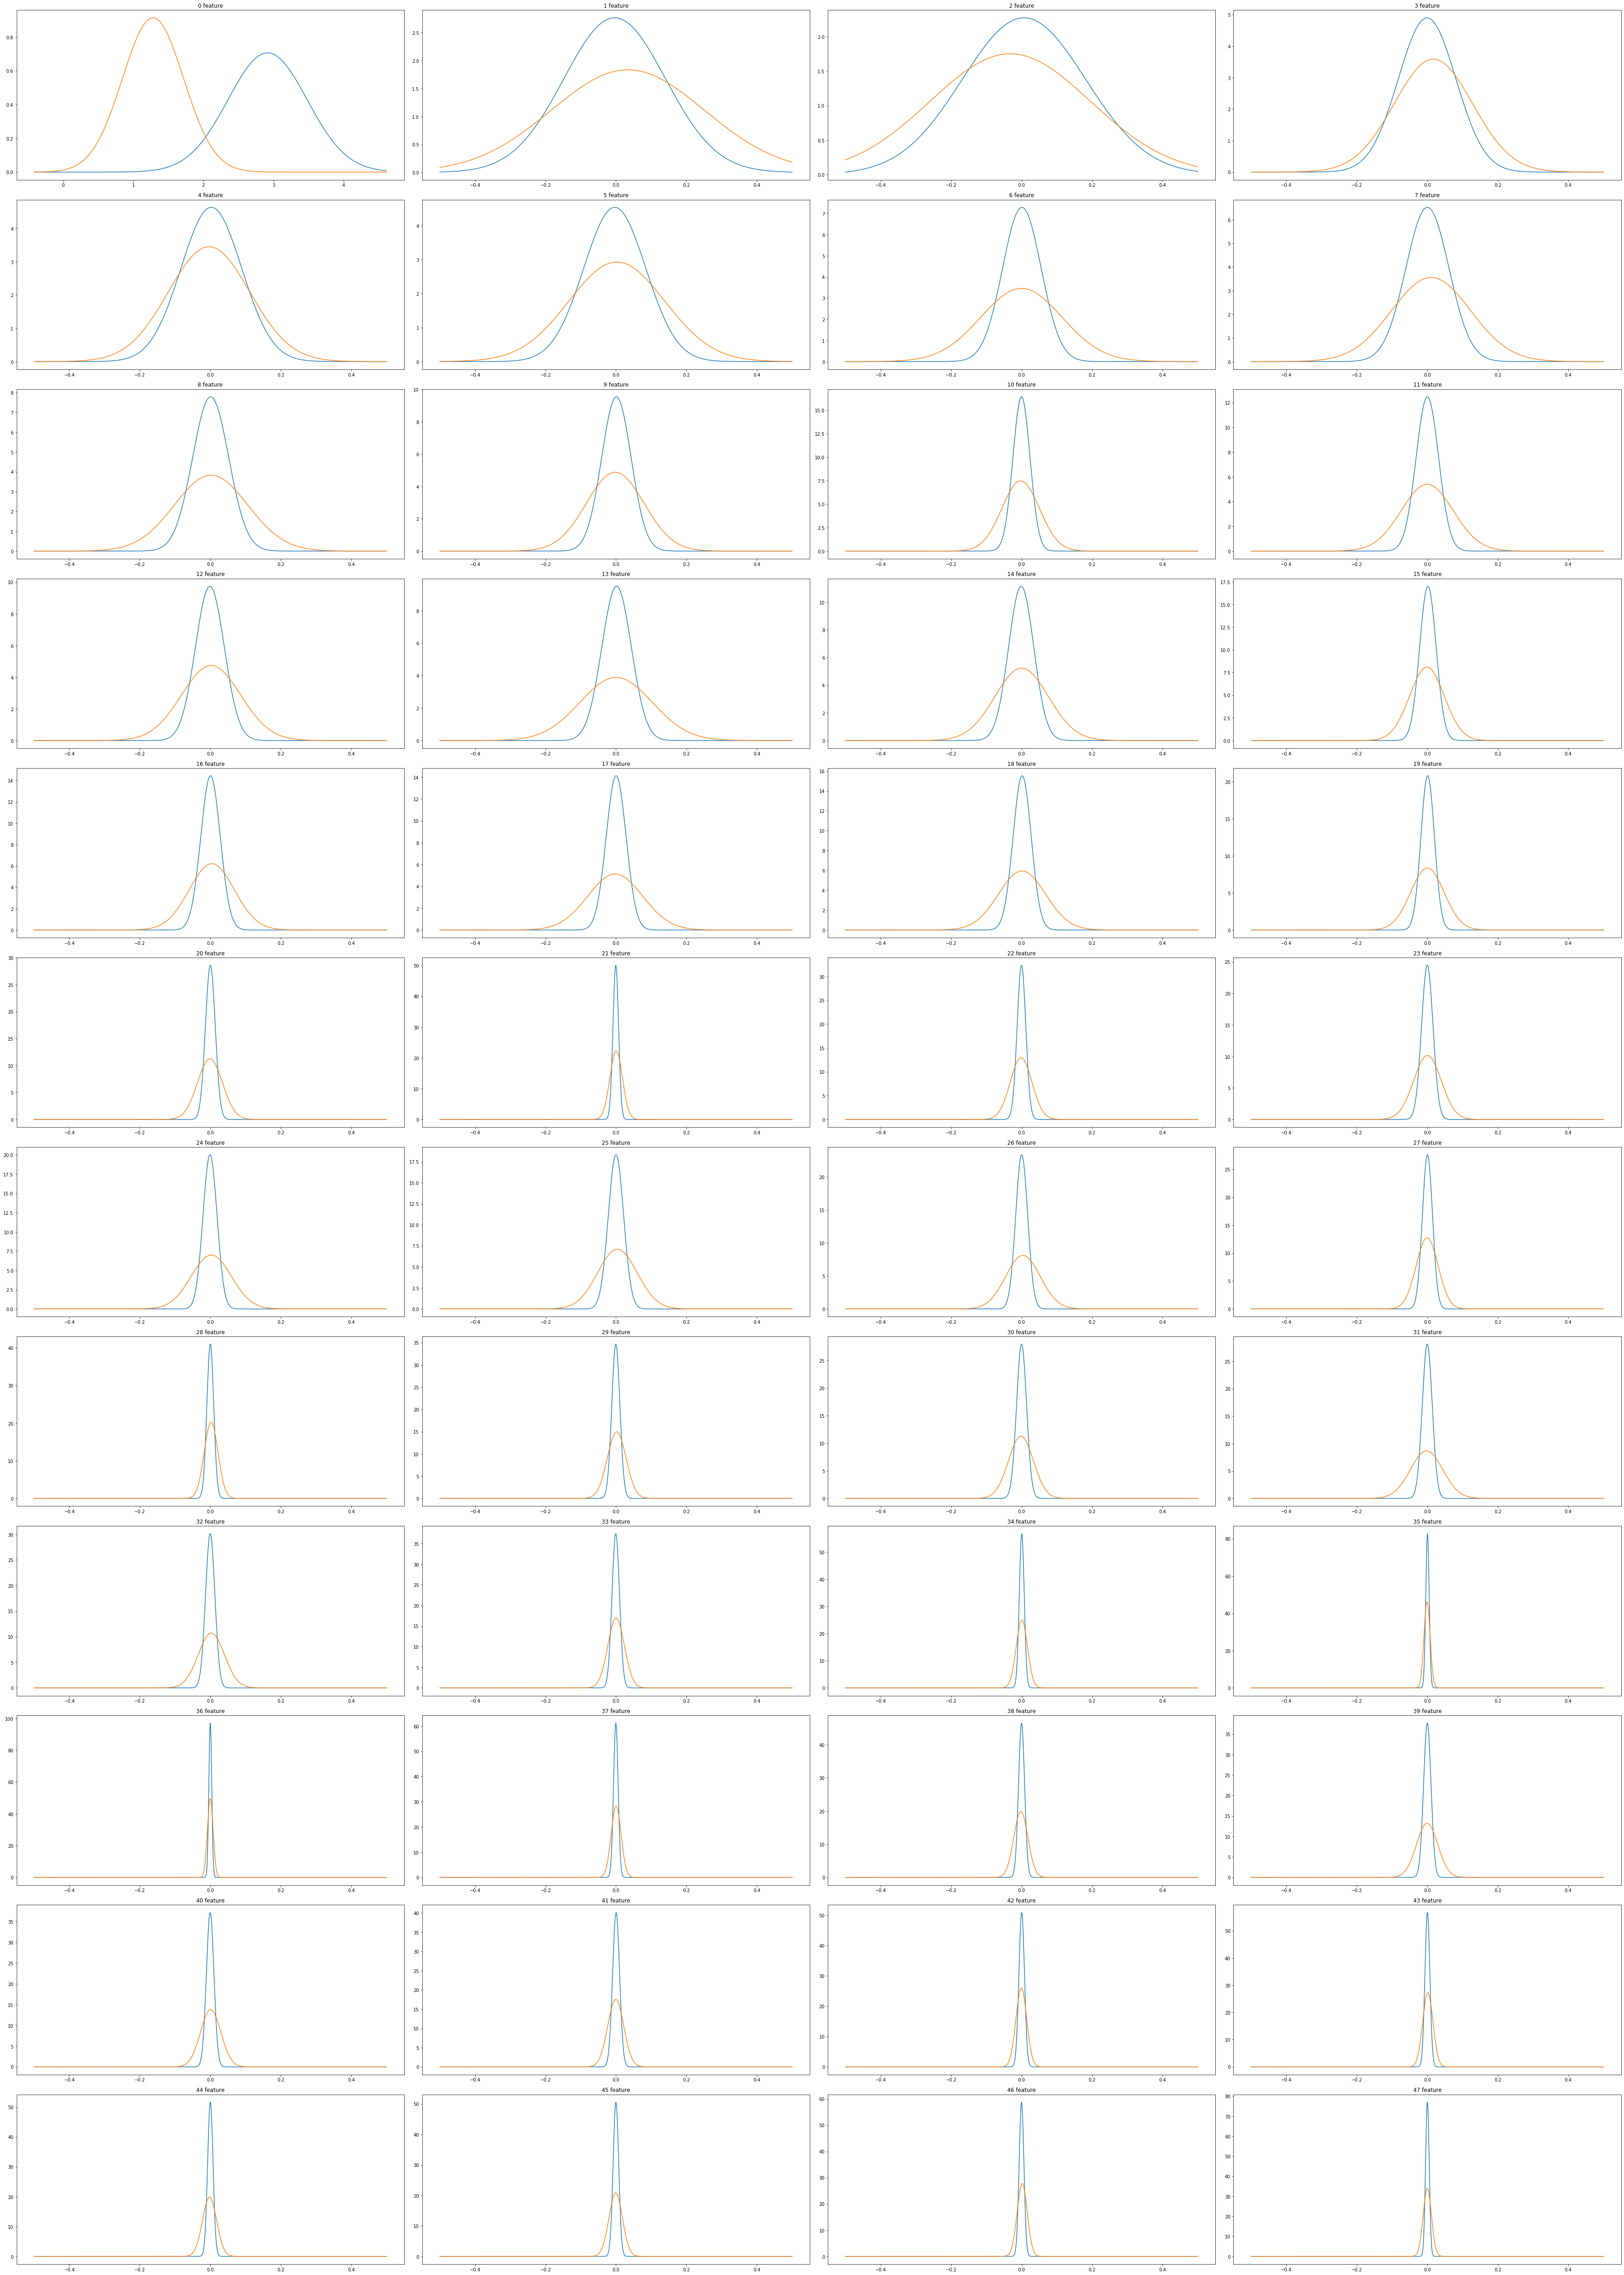

In [88]:
import matplotlib.pyplot as plt
import scipy.stats as stats

fig, axs = plt.subplots(nrows=12, ncols=4, figsize=(50, 70))

for i, ax in enumerate(axs.flat):
    ax.title.set_text("{} feature".format(i))
    sigma0 = np.sqrt(var_0[i, i])
    mu0 = mu_0[i]
    sigma1 = np.sqrt(var_1[i, i])
    mu1 = mu_1[i]
    if i == 0:
        x = np.linspace(min(mu0, mu1) - 3*max(sigma0, sigma1), max(mu0, mu1) + 3*max(sigma0, sigma1), 1000)
    else:
        x = np.linspace(-0.5, 0.5, 1000)
    ax.plot(x, stats.norm.pdf(x, mu0, sigma0), x, stats.norm.pdf(x, mu1, sigma1))

plt.tight_layout()
plt.show()

#### Plot best 9 features:

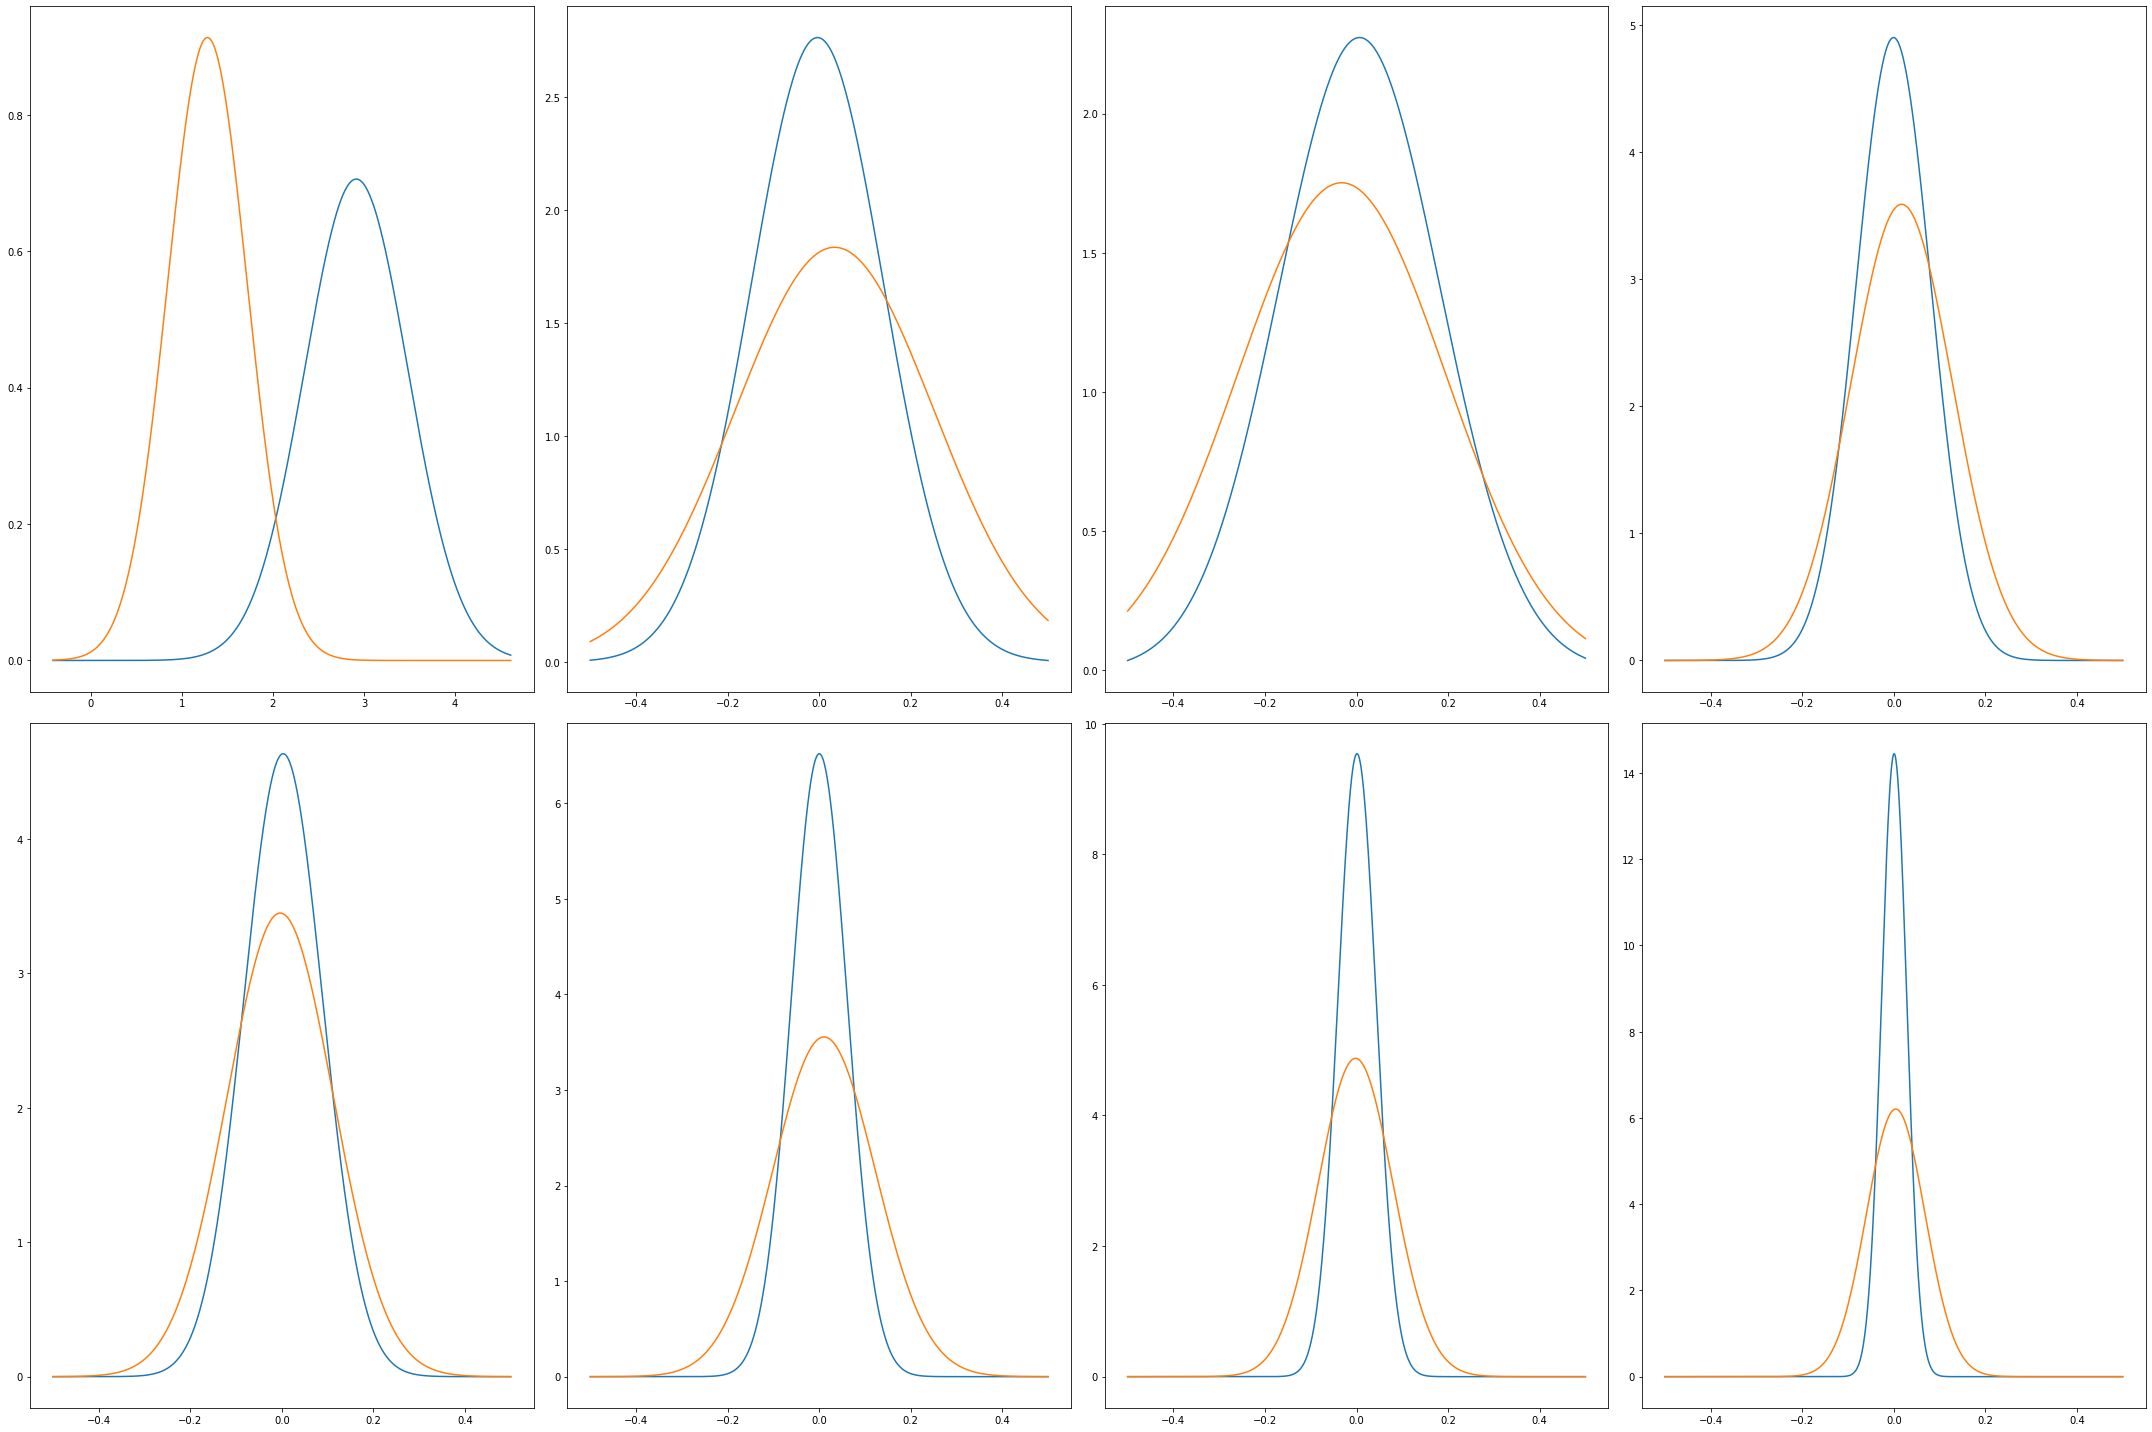

In [98]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(30, 20))

best_index = [0,1,2,3,4,7,9,16]
worst_index = [34,35,36,37,42,43,46,47]
for i, ax in enumerate(axs.flat):
    j = best_index[i]
    sigma0 = np.sqrt(var_0[j, j])
    mu0 = mu_0[j]
    sigma1 = np.sqrt(var_1[j, j])
    mu1 = mu_1[j]
    if i == 0:
        x = np.linspace(min(mu0, mu1) - 3*max(sigma0, sigma1), max(mu0, mu1) + 3*max(sigma0, sigma1), 1000)
    else:
        x = np.linspace(-0.5, 0.5, 1000)
    ax.plot(x, stats.norm.pdf(x, mu0, sigma0), x, stats.norm.pdf(x, mu1, sigma1))

plt.tight_layout()
plt.show()

#### Plot worst 8 features:

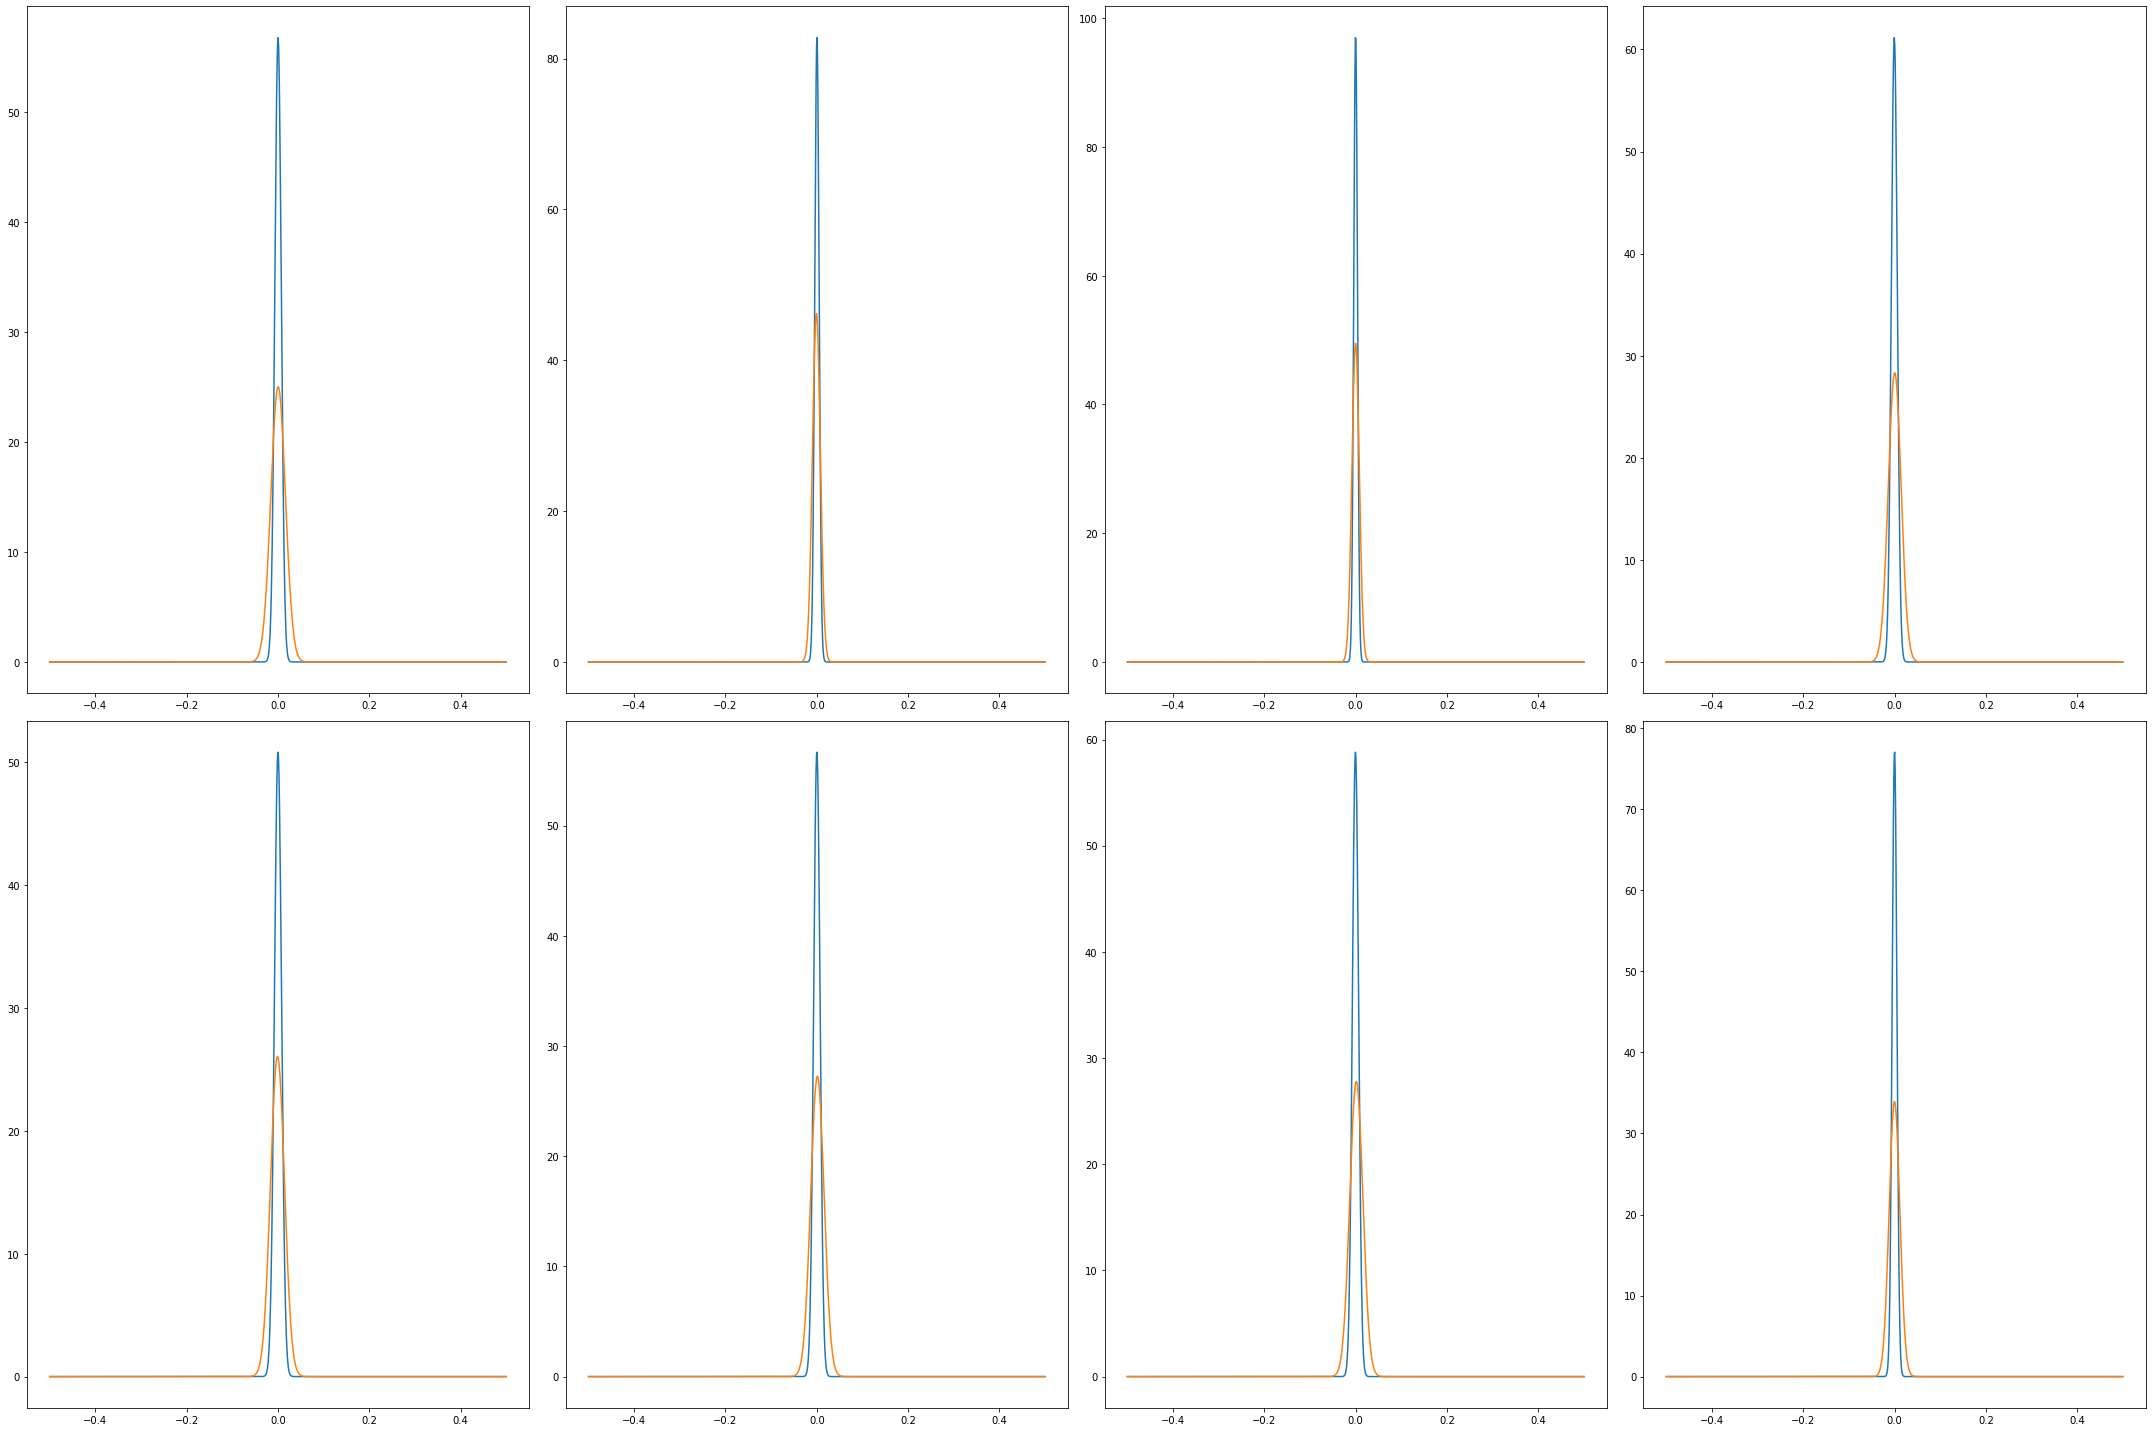

In [92]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(30, 20))
for i, ax in enumerate(axs.flat):
    j = worst_index[i]
    sigma0 = np.sqrt(var_0[j, j])
    mu0 = mu_0[j]
    sigma1 = np.sqrt(var_1[j, j])
    mu1 = mu_1[j]
    x = np.linspace(-0.5, 0.5, 1000)
    ax.plot(x, stats.norm.pdf(x, mu0, sigma0), x, stats.norm.pdf(x, mu1, sigma1))

plt.tight_layout()
plt.show()

### Question C

In [4]:
# Question C:
from scipy.fftpack import dct

# import zig-zag pattern
with open("Zig-Zag Pattern.txt", "r") as f:
    content = f.readlines()
    
zigzag = []
for line in content:
    index = []
    for num in line.strip().split(" "):
        if num != "":
            index.append(int(num))
    if index!=[]:        
        zigzag.append(index)
zigzag = np.array(zigzag)

def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def gen_zigzag_arr(block):
    arr = np.zeros(64)
    for i, line in enumerate(zigzag):
        for j, index in enumerate(line):
            arr[index] = block[i, j]
    return arr

In [6]:
from PIL import Image
import numpy as np
img = Image.open("cheetah.bmp", "r")
img = np.array(img) 

def slicing(img):
    out = []
    for i in range(len(img) - 7):
        out.append([])
        for j in range(len(img[i]) - 7):
            window = img[i:i+8, j:j+8]
            dct_result = dct2(window)
            arr = gen_zigzag_arr(dct_result)
            out[i].append(arr)
    return out
X_processed = np.array(slicing(img))

15.620820999145508


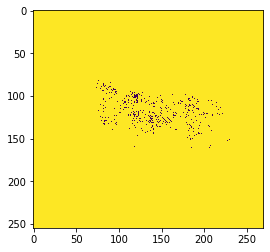

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import time
best_index = [0,1,2,3,4,7,9,16]
start = time.time()
def Gaussian_classifier(x, mu, var, prior):
    w_2 = np.linalg.inv(var)
    w_1 = -2 * np.matmul(w_2, mu)
    w_0 = np.dot(mu.T, -1/2*w_1) + np.log(np.linalg.det(w_2)) - 2*np.log(prior)
    return np.dot(x.T, np.matmul(w_2, x)) + np.dot(w_1, x) + w_0


def Gaussian_classifier_8features(x, mu, var, prior):
    x = x[best_index]
    mu = mu[best_index]
    var = var[best_index][:,best_index]
    w_2 = np.linalg.inv(var)
    w_1 = -2 * np.matmul(w_2, mu)
    w_0 = np.dot(mu.T, -1/2*w_1) + np.log(np.linalg.det(w_2)) - 2*np.log(prior)
    return np.dot(x.T, np.matmul(w_2, x)) + np.dot(w_1, x) + w_0

mask = np.ones((X_processed.shape[0] + 7, X_processed.shape[1] + 7))
for i in range(len(X_processed)):
    for j in range(len(X_processed[i])):
        result0 = Gaussian_classifier(X_processed[i,j], mu_0, var_0, prior_0)
        result1 = Gaussian_classifier(X_processed[i,j], mu_1, var_1, prior_1)
        if result1 < result0:
            mask[i + 4,j + 4] = 0
        else:
            mask[i + 4,j + 4] = 1
print(time.time() - start)
plt.imshow(mask)
plt.show()
